GENERATION OF SYNTHETIC CREDIT RISK DATASET


In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 5000

# Basic demographic + financial variables
age = np.random.randint(21, 70, n)
income = np.random.randint(20000, 200000, n)
loan_amount = np.random.randint(5000, 500000, n)
credit_limit = np.random.randint(10000, 800000, n)

# Engineered realistic variables
credit_utilization = np.round(np.random.uniform(0.05, 1.2, n), 2)
previous_defaults = np.random.poisson(0.3, n)
num_of_loans = np.random.randint(1, 12, n)
emi = loan_amount / np.random.randint(12, 60, n)

# Debt-to-income ratio
dti = np.round((emi * num_of_loans) / income, 2)

# Savings
savings = np.random.randint(5000, 500000, n)

# Target: probability depends on risky behaviour
risk_score = (
    0.4*credit_utilization +
    0.3*dti +
    0.2*(previous_defaults>0).astype(int) +
    0.1*np.random.rand(n)
)

default = (risk_score > risk_score.mean()).astype(int)

# Build final dataset
df = pd.DataFrame({
    "age": age,
    "income": income,
    "loan_amount": loan_amount,
    "credit_limit": credit_limit,
    "credit_utilization": credit_utilization,
    "previous_defaults": previous_defaults,
    "num_of_loans": num_of_loans,
    "emi": emi,
    "dti": dti,
    "savings": savings,
    "default": default
})

df.head()


,age,income,loan_amount,credit_limit,credit_utilization,previous_defaults,num_of_loans,emi,dti,savings,default
0,59,45963,282392,58582,0.25,0,1,18826.133333,0.41,167651,0
1,49,63954,466263,303238,1.16,0,6,8634.500000,0.81,30090,1
2,35,115430,291370,725995,0.66,0,7,10791.481481,0.65,389552,0
3,63,20717,423241,294331,0.69,0,11,24896.529412,13.22,13828,1
4,28,31676,243922,663009,1.09,0,8,7868.451613,1.99,319624,1


PREPROCSSING AND FEATURE ENGINEERING AND SPLITING TRAIN - TEST + SCALING

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df["credit_usage_ratio"] = df["loan_amount"] / df["credit_limit"]
df["income_to_emi_ratio"] = df["income"] / (df["emi"] + 1)
df["loan_per_year_age"] = df["num_of_loans"] / df["age"]
df["savings_to_income"] = df["savings"] / df["income"]
df["risk_burden"] = (df["dti"] + df["credit_utilization"]) / 2

features = df.drop("default", axis=1)
target = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


TRAIN XG BOOST MODEL

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

model = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.9664
Precision: 0.9649122807017544
Recall: 0.953757225433526
AUC: 0.9955059319063019


SHAP GLOBAL INTERPRETABILITY

/tmp/ipython-input-1186275201.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="dot")


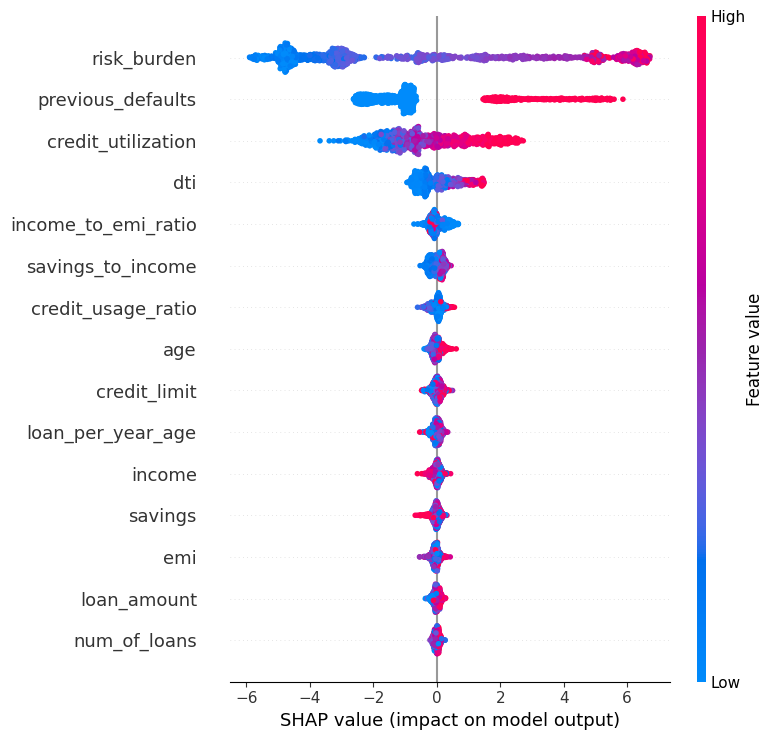

/tmp/ipython-input-1186275201.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


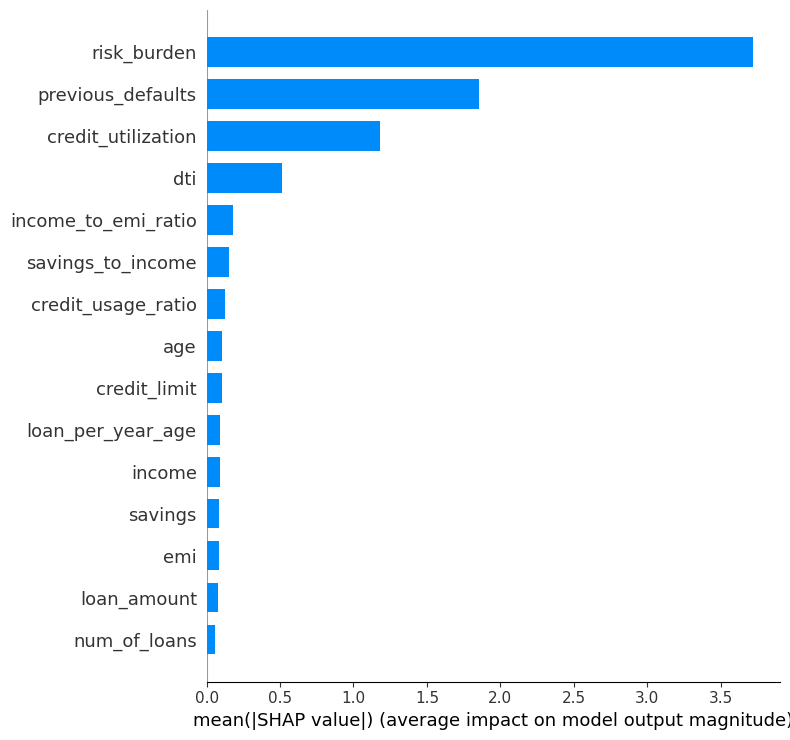

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plots
shap.summary_plot(shap_values, X_test, plot_type="dot")
shap.summary_plot(shap_values, X_test, plot_type="bar")


RESET INDEX TO AVOID SHAP ERRORS

In [9]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred).reset_index(drop=True)


In [10]:
false_positive_idx = X_test_reset[(y_pred_reset == 1) & (y_test_reset == 0)].index[0]
false_negative_idx = X_test_reset[(y_pred_reset == 0) & (y_test_reset == 1)].index[0]
correct_positive_idx = X_test_reset[(y_pred_reset == 1) & (y_test_reset == 1)].index[0]

false_positive_idx, false_negative_idx, correct_positive_idx


(np.int64(101), np.int64(52), np.int64(1))

In [12]:
import shap
shap.initjs()


SHAP Local Force Plots False Positive

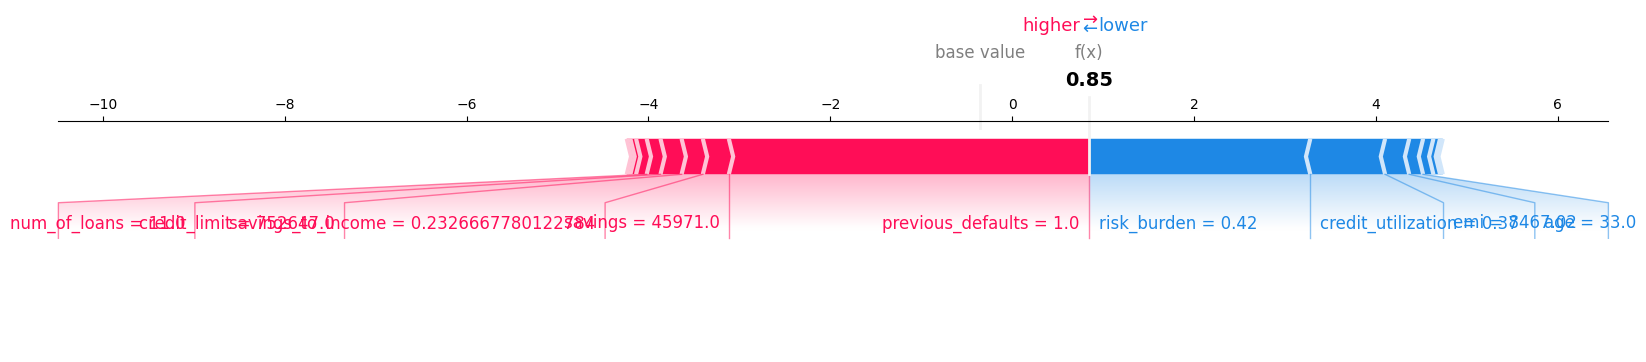

In [14]:
shap.force_plot(
    explainer.expected_value,
    shap_values[false_positive_idx],
    X_test_reset.iloc[false_positive_idx],
    matplotlib=True
)


False Negative

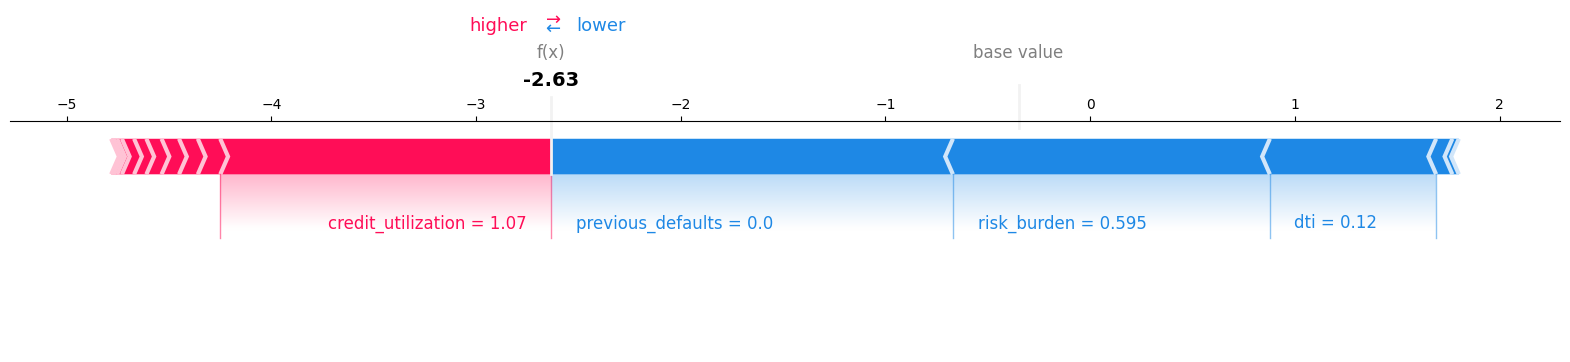

In [15]:
shap.force_plot(
    explainer.expected_value,
    shap_values[false_negative_idx],
    X_test_reset.iloc[false_negative_idx],
    matplotlib=True
)


Correct Positive

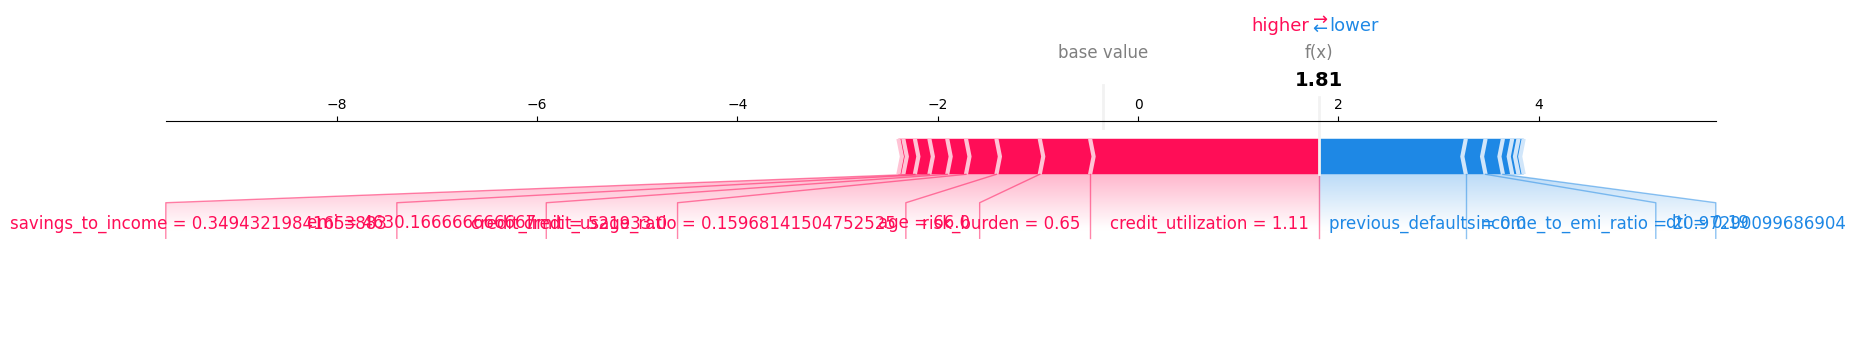

In [16]:
shap.force_plot(
    explainer.expected_value,
    shap_values[correct_positive_idx],
    X_test_reset.iloc[correct_positive_idx],
    matplotlib=True
)
